In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pprint import pprint as pp
from pathlib import Path

from speech2text.audio_data import WavData, PdData, NpData

pass

In [3]:
IN_FILE_ROOT_PATH = Path("../../tests/audio_samples")
IN_FILE_PATH = IN_FILE_ROOT_PATH / "en_chunk.wav"

## 1. Wave

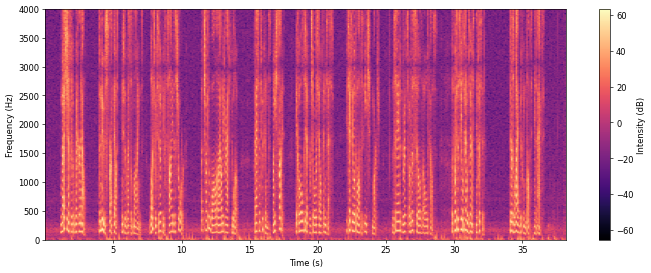

In [4]:
# WavData demo

wav_data = WavData.load_from_wav_file(IN_FILE_PATH)
wav_data.ipy_show_player()
wav_data.ipy_show_specgram()

empty = WavData(wav_data.pcm_params)
for chunk in wav_data.split_in_chunks():
    empty.append_chunk(chunk)
assert wav_data.raw_data == empty.raw_data

## 2. PyDub

In [ ]:
# PdAudio demo

audio: PdData = PdData.load_from_wav_file(IN_FILE_PATH)
audio.ipy_show_player()
audio.ipy_show_specgram()
pp(audio.dBFS)
audio = audio.adjust_pcm_params()
audio.ipy_show_player()
audio.ipy_show_specgram()
pp(audio.dBFS)

In [ ]:
# Cut off frequancies
audio_ = audio[:]
audio_ = audio_.high_pass_filter(300)
audio_ = audio_.low_pass_filter(3500)
audio.ipy_show_specgram()
audio_.ipy_show_player()
audio_.ipy_show_specgram()

In [ ]:
# Speed up, Volum up

audio_ = audio[:]
audio_ = audio_.speedup(1.2)
audio_.ipy_show_player()

audio_ += 5
audio_.ipy_show_player()

In [ ]:
# Silence splitting
audio_ = audio[:]
audio_ = (
    PdData.load_from_wav_file(IN_FILE_ROOT_PATH / "en_hedgehog.wav")
    # .speedup(1.2)
    .low_pass_filter(300)
    .high_pass_filter(3500)
    .adjust_pcm_params()
    .normalize()
    # + 5 # make it louder
)
audio_.ipy_show_player()

pp("===" * 10)
segments = audio_.split_on_silence(
    min_silence_len=1000, silence_thresh=-30, keep_silence=1000, seek_step=10
)
for i in range(min(10, len(segments))):
    segments[i].ipy_show_player()
    segments[i].ipy_show_specgram()

## 3. `np`-based

In [ ]:
display(NpData.__bases__)
np_data = NpData.load_from_pd_data(audio)
display(np_data.__class__)
np_data.ipy_show_player()
np_data.ipy_show_specgram()

assert np_data.pcm_params == audio.pcm_params

### 3.1 `noisereduce`

In [ ]:
from speech2text.transcriber.noisereduce import reduce_noise

np_data_ = reduce_noise(np_data)
np_data.ipy_show_player()
np_data.ipy_show_specgram()
np_data_.ipy_show_player()
np_data_.ipy_show_specgram()

### 3.2 `whisper`

In [ ]:
from speech2text.transcriber.noisereduce import transcribe, _pick_whisper_model

_pick_whisper_model("small.en")
_pick_whisper_model("tiny.en")

whisper_model_params = {
    "verbose": False,
    "temperature": (0, 0.2, 0.4, 0.6, 0.8, 1),
    "compression_ratio_threshold": 2.4,
    "no_speech_threshold": 0.6,
    "condition_on_previous_text": True,
    "initial_prompt": None,
    "word_timestamps": False,
    "clip_timestamps": "0",
    "hallucination_silence_threshold": None,
}
speed_up = 1.0
min_silence_len = 800


min_silence_len = int(min_silence_len / speed_up)
audio = (
    PdData.load_from_wav_file(IN_FILE_ROOT_PATH / "en_hedgehog.wav")
    .speedup(speed_up)
    .low_pass_filter(300)
    .high_pass_filter(3500)
    .adjust_pcm_params()
    .normalize()
    # + 5 # make it louder
)
audio.ipy_show_player()
segments = audio.split_on_silence(
    min_silence_len=min_silence_len,
    silence_thresh=-30,
    keep_silence=min_silence_len,
    seek_step=10,
)

for segment in segments[:10]:
    np_segment = NpData.load_from_pd_data(segment)
    np_segment = reduce_noise(np_segment)

    tr_segment = transcribe(np_segment, **whisper_model_params)
    np_segment.ipy_show_player()
    pp(tr_segment["text"])
    np_segment.ipy_show_specgram(dpi=40)
    # break

## Chunck queue pipeline

In [ ]:
from typing import List

from speech2text.transcriber.noisereduce import transcribe, reduce_noise

wav_data = (
    PdData.load_from_wav_file(IN_FILE_ROOT_PATH / "en_chunk.wav")
    .adjust_pcm_params()
    .create_wav_data()
)  # en_hedgehog.wav en_news.wav en_chunk.wav


pcm_params = wav_data.pcm_params


def chunk_iterator(chunk_len_sec: float):
    for chunk in wav_data.split_in_chunks(chunk_len_sec):
        yield chunk


sos_params = {
    "min_silence_len": 1000,
    "silence_thresh": -30,
    "keep_silence": 800,
    "seek_step": 10,
}

text_lines: List[str] = []
previous_pd_blocks: List[PdData] = []
current_block: WavData = None
current_block_text = None

for chunk in chunk_iterator(0.8):
    if current_block is None:
        current_block = WavData(pcm_params)
    current_block.append_chunk(chunk)
    pd_block = PdData.load_from_wav_file(current_block)
    # pd_block.ipy_show_player()
    previous_pd_blocks = pd_block.split_on_silence(**sos_params)
    if not previous_pd_blocks:
        current_block = None
        continue
    pd_block = previous_pd_blocks.pop()

    init_prompt = text_lines[-1] + ". " if text_lines else None
    for prev_block in previous_pd_blocks:
        prev_block = (
            prev_block.low_pass_filter(300).high_pass_filter(3500).normalize()
        )
        np_data = NpData.load_from_pd_data(prev_block)
        np_data = reduce_noise(np_data)
        transcription = transcribe(
            np_data,
            "tiny.en",
            initial_prompt=init_prompt,
            # condition_on_previous_text=False,
        )
        init_prompt = transcription["text"]
        text_lines.append(transcription["text"])

    if previous_pd_blocks:
        current_block = pd_block.create_wav_data()
    np_data = NpData.load_from_pd_data(pd_block)
    transcription = transcribe(
        np_data,
        "tiny.en",
        initial_prompt=init_prompt,
        # condition_on_previous_text=False,
    )
    current_block_text = transcription["text"]
    current_block.ipy_show_player()
    pp(text_lines)
    pp(current_block_text)

# small.en - small.en
# 1.5 >>= low_pass_filter + high_pass_filter + normalize + reduce_noise == 31/38
# 1.5 >>= low_pass_filter + high_pass_filter + normalize == 27/38
# 1.5 >>= reduce_noise == 25/38
# 1.5 >>= == 25/38
# 1.0 >>= == 33/38
# 0.8 >>= == 56/38

# tiny.en - small.en
# 0.8 >>= == 22/38

# tiny.en - tiny.en
# 0.8 >>= == 17/38